In [37]:
import requests, re, os, yaml, time, io, pandas as pd

# plt.style.use('fivethirtyeight')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [38]:
def get_cookie_crumb(ticker):
    url = 'https://finance.yahoo.com/quote/{ticker}/history'.format(ticker=ticker) # url for a ticker symbol, with a download link
    r = requests.get(url)  # download page
    txt = r.text # extract html

    cookie = r.cookies['B'] # the cookie we're looking for is named 'B'
    
    # Now we need to extract the token from html. 
    # the string we need looks like this: "CrumbStore":{"crumb":"lQHxbbYOBCq"}
    # regular expressions will do the trick!
    
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    
    for line in txt.splitlines():
        m = pattern.match(line)
        
        if m is not None:
            crumb = m.groupdict()['crumb']
        
    return cookie, crumb

In [63]:
def get_historical_price_data(tickers, start, end, frequency):

    # Set up
    start = int(time.mktime(time.strptime(start, "%Y-%m-%d")))
    end = int(time.mktime(time.strptime(end, "%Y-%m-%d")))
    data_dir = 'C:/Users/akashyap/Downloads/Jupyter/'
    
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    assert frequency in ['daily', 'weekly', 'monthly'], 'Frequency has to be daily, weekly, or monthly.'
    
    if frequency == 'daily':
        frequency = '1d'
    elif frequency == 'weekly':
        frequency = '1wk'
    else:
        frequency = '1m'
            
    for ticker in tickers:
        
        cookie, crumb = get_cookie_crumb(ticker)
        
        # save data to YAML file
        data = {'cookie':cookie,'crumb':crumb}

        data_file = os.path.join(data_dir, 'yahoo_cookie.yml')

        with open(data_file,'w') as fid:
            yaml.dump(data, fid)

        url = "https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start}&period2={end}&interval={frequency}&events=history&crumb={crumb}".format(ticker=ticker, start=start, end=end, frequency=frequency, crumb=crumb)

        print(url)
    
        data = requests.get(url, cookies={'B':cookie})
    
        buffer = io.StringIO(data.text) # create a buffer
        df = pd.read_csv(buffer) # convert to pandas DataFrame
        df['Ticker'] = ticker
        df = df.append(df)
    
#     df.rename(columns={"Adj Close": "Adj_Close"}, inplace=True)
#     df.index = pd.to_datetime(df.Date)
#     df.drop("Date", inplace=True, axis=1)
#     df = df[['Ticker','Open','High','Low','Close','Adj_Close','Volume']]
#     df = df.sort_index()
    
    return df

In [64]:
tickers = ['AMZN', 'GOOG']
start = '2005-01-01'
end = '2019-10-02'
frequency = 'daily'

df = get_historical_price_data(tickers, start, end, frequency)
# df.head()
df.to_csv('output.csv')

https://query1.finance.yahoo.com/v7/finance/download/AMZN?period1=1104517800&period2=1569954600&interval=1d&events=history&crumb=YSdEi.3z1eC
https://query1.finance.yahoo.com/v7/finance/download/GOOG?period1=1104517800&period2=1569954600&interval=1d&events=history&crumb=ZPohSFFb6gH


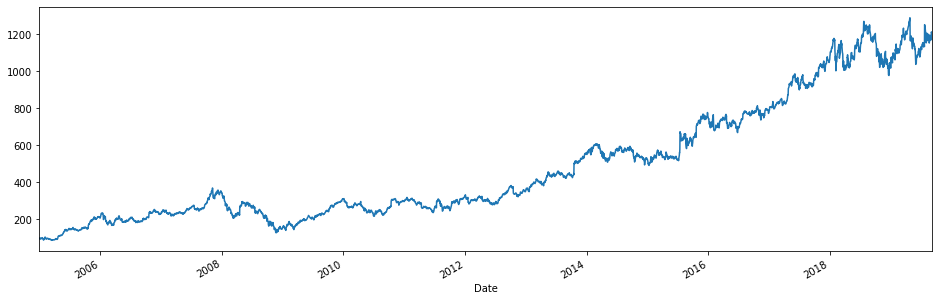

In [15]:
df.Close.plot(figsize=(16,5))